# Generate music with an RNN

This notebook shows how to generate musical notes using a Recurrent Neural Network. The model is trained using a collection of piano MIDI files from the [MAESTRO dataset](https://magenta.tensorflow.org/datasets/maestro). Given a sequence of notes, the model learns to predict the next note in the sequence.

First the program asks the user a voice record of 10 seconds and a picture of his/her face, files which will be used as initialization for the model and for the emotion detection

Then the model is defined and trained
(The train is not needed, the model has already been trained, check the README)

Finally, new notes are generated according to the model, emotion and initial voice recording


# Setup

## Record Voice

In [1]:
!pip -q install pydub
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
from pydub import AudioSegment

In [2]:
RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=10): # change here the duration of the recording
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b)) # remove this line if you want to save the audio without playing it
  with open('voice.wav','wb') as f:
    f.write(b)
  return audio

### Remember to allow the microphone and the camera to be used in the browser

In [3]:
record()

<IPython.core.display.Javascript object>

## Smile Detection

In [6]:
import cv2
import dlib
import numpy as np

In [88]:
def is_smiling(landmarks):
    # Get the coordinates of the mouth landmarks
    # Points for the left and right of the mouth
    left_mouth = (landmarks.part(48).x, landmarks.part(48).y)
    right_mouth = (landmarks.part(54).x, landmarks.part(54).y)

    # Points for the top and bottom of the mouth
    top_mouth = (landmarks.part(51).x, landmarks.part(51).y)
    bottom_mouth = (landmarks.part(57).x, landmarks.part(57).y)

    # Calculate distances
    horizontal_dist = np.linalg.norm(np.array(left_mouth) - np.array(right_mouth))
    vertical_dist = np.linalg.norm(np.array(top_mouth) - np.array(bottom_mouth))

    # Aspect ratio
    aspect_ratio = vertical_dist / horizontal_dist

    # Threshold can be adjusted based on empirical data
    smile_threshold = 0.2

    return aspect_ratio < smile_threshold


In [62]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [63]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = output.eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  #for (x,y,w,h) in faces:
  #    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [64]:
# Initialize dlib's face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")  # You need to download this file

In [ ]:
from IPython.display import display, Javascript, Image
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  photo = cv2.imread('photo.jpg')
  gray = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)

  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")  # You need to download this file

  faces = detector(gray)
  if len(faces) == 0:
    print("no face detected, please try again")

  else:
    for face in faces:
      print("face found")
      landmarks = predictor(gray, face)

    if is_smiling(landmarks):
      color = (0, 255, 0) # Green
    else:
      color = (0, 0, 255) # Red

    x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()
    cv2.rectangle(photo, (x1, y1), (x2, y2), color, 2)

    cv2.imwrite(filename, photo)
    # Show the image which was just taken.
    display(Image(filename))
    label = 1 if is_smiling(landmarks) else -1
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Import the necessary libraries

In [ ]:
!pip install basic-pitch
!basic-pitch /content/ voice.wav

The `pretty_midi` library is used to create and parse MIDI files, and `pyfluidsynth` library for generating audio from the MIDI files.

In [ ]:
!pip install fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

In [4]:
import collections
import datetime
import fluidsynth
import glob
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
import time
import threading
import pickle
from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [7]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000


Modify the paths:
1) Where to save the midi file
2) The file to convert

# Model definition

## Download the Maestro dataset

In [29]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

In [30]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Function to play a MIDI file

In [18]:
recorded_file = "voice_basic_pitch.mid"
pm = pretty_midi.PrettyMIDI(recorded_file)

In [8]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=10):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [19]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Electric Piano 1


## Extract and analyze notes

In [20]:
# print the first ten notes
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=61, note_name=C#4, duration=0.1614
1: pitch=64, note_name=E4, duration=0.2205
2: pitch=56, note_name=G#3, duration=0.5477
3: pitch=61, note_name=C#4, duration=0.6727
4: pitch=61, note_name=C#4, duration=0.2318
5: pitch=56, note_name=G#3, duration=0.7545
6: pitch=64, note_name=E4, duration=1.0932
7: pitch=61, note_name=C#4, duration=0.2318
8: pitch=64, note_name=E4, duration=0.6977
9: pitch=61, note_name=C#4, duration=0.2227


To train the model, three elements of each note are used: _**pitch**_, _**step**_ and _**duration**_.
- _**pitch**_ is the perceptual quality of the sound as a MIDI note number.
- _**step**_ is the time elapsed from the previous note or start of the track.
- _**duration**_ is how long the note will be playing in seconds and is the difference between the note end and note start times.


Extract the notes from the sample MIDI file and create a DataFrame.

In [21]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [23]:
raw_notes = midi_to_notes(recorded_file)
raw_notes.head()

,pitch,start,end,step,duration
0,61,0.059091,0.220455,0.000000,0.161364
1,64,0.138636,0.359091,0.079545,0.220455
2,56,0.150000,0.697727,0.011364,0.547727
3,61,0.220455,0.893182,0.070455,0.672727
4,64,0.359091,1.452273,0.138636,1.093182


We can visualize the file plotting the note pitch, start and end across the length of the track.

In [24]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

Plot the notes for the entire track.

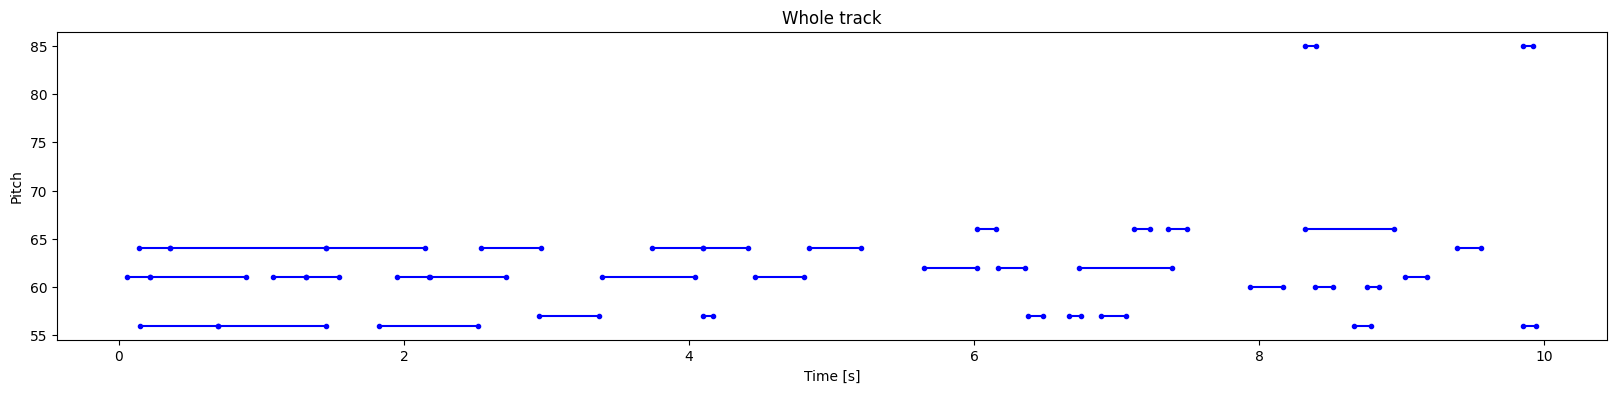

In [25]:
plot_piano_roll(raw_notes)

## From list of notes to MIDI file

In [26]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

## Build the training dataset


Extract notes from the MIDI files.

In [95]:
num_files = 750
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [33]:
n_notes = len(all_notes)
print('Number of total notes for training:', n_notes)

Number of total notes for training: 188


Create a _tf.data.Dataset_ from the collected notes.

In [96]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [97]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

We train the model on batches of sequences of notes. Each example consists of a sequence of notes as the input features, and the next note as the label. In such way, the model will be trained to predict the next note in a sequence.

Use the `window` function with size `seq_length` to create the features and labels.

In [36]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` creates a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example.
The size of the vocabulary `vocab_size` is set to 128 representing all the possible pitch values supported by `pretty_midi`.

In [98]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is ```(100,1)```, meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [99]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.703125   0.         0.109375  ]
 [0.515625   0.00208333 0.06041667]
 [0.4765625  0.00625    0.059375  ]
 [0.453125   0.         0.06979167]
 [0.421875   0.0125     0.03854167]
 [0.734375   0.06875    0.109375  ]
 [0.6640625  0.08333333 0.08229167]
 [0.4921875  0.075      0.07395833]
 [0.4609375  0.00208333 0.06145833]
 [0.515625   0.00104167 0.07708333]], shape=(10, 3), dtype=float64)
target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=42.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.002083333333333437>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.033333333333333215>}


Batch the examples, and configure the dataset for performance.

In [100]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

## Define the model

The model will have three outputs, one for each note variable. For `step` and `duration`, use a loss function based on mean squared error that encourages the model to output non-negative values.

In [40]:
def non_negative_mse(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [41]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, activation='relu', name='pitch')(x),
  'step': tf.keras.layers.Dense(1, activation='relu', name='step')(x),
  'duration': tf.keras.layers.Dense(1, activation='relu', name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': non_negative_mse,
      'duration': non_negative_mse,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                
                                                                                              

The `pitch` loss is significantly greater than the `step` and `duration` losses.
One way balance this is to use the `loss_weights` argument to compile:
<br> the total loss then becomes the weighted sum of the individual losses.

In [42]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

214/214 [==============================] - 2s 3ms/step - loss: 1.1704 - duration_loss: 0.7957 - pitch_loss: 4.8611 - step_loss: 0.1316


{'loss': 1.1704301834106445,
 'duration_loss': 0.7957400679588318,
 'pitch_loss': 4.861086368560791,
 'step_loss': 0.13163532316684723}

## Train the model

In [101]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

In [ ]:
model.save("music_generator.h5")

Plot the model loss over epochs

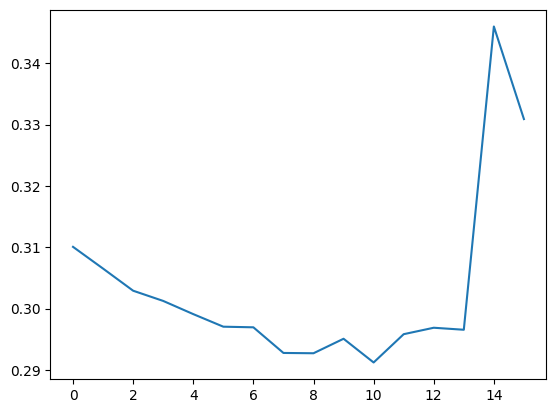

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

# New notes generation

To use the model to generate notes, first we provide a starting sequence of notes. This sequence of notes is given by the user, humming a melody and recording it.
The recording is then converted into a MIDI file and used as initial input for the generation.

The `temperature` parameter is used to control the randomness of notes subsequently generated.

## Import trained KMeans model, define MIDI analyzer function

In [44]:
with open("model.pkl", "rb") as f:
    kmeans_model = pickle.load(f)

In [45]:
def analyze_midi(notes_sequence):

    # suppose the triple for each note is: (pitch, step, duration)
    # get notes steps
    steps = [note[1] for note in notes_sequence]

    avg_step = np.mean(steps)
    max_step = np.max(steps)
    std_step = np.std(steps)


    # get note durations
    durations = [note[2] for note in notes_sequence]

    avg_duration = np.mean(durations)
    max_duration = np.max(durations)
    std_duration = np.std(durations)

    # get note pitches
    pitches = [note[0] for note in notes_sequence]

    avg_pitch = np.mean(pitches)
    max_pitch = np.max(pitches)
    std_pitch = np.std(pitches)


    return {
        'avg_step': avg_step,
        'max_step': max_step,
        'std_step': std_step,
        'avg_duration': avg_duration,
        'max_duration': max_duration,
        'std_duration': std_duration,
        'avg_pitch': avg_pitch,
        'max_pitch': max_pitch,
        'std_pitch': std_pitch
    }

## Functions to guide the choice of the next note

In [46]:
import scipy.special

def emotion_classifier(notes_sequence, current_emotion):

    notes_features = analyze_midi(notes_sequence)
    notes_features = np.array([value for value in notes_features.values()])
    notes_features = notes_features.reshape(1, -1)

    kmeans_model.transform(notes_features)

    # Calculate distances from centroids
    distances = kmeans_model.transform(notes_features.reshape(1, -1))
    softmax_distances = 1 - scipy.special.softmax(distances[0])
    emotion = 1 if current_emotion == 1 else 0

    # Find the index of the nearest cluster centroid
    emotion_score = softmax_distances[emotion]

    # Now we have the index of the nearest cluster centroid,
    # Use it to classify the new point
    print("Predicted score for the new point:", emotion_score)

    return emotion_score


def pitch_logits_emotion_encloser(notes_sequence, pitches, pitch_logits, step, duration, label):

    # To tune hyperparameters
    alpha = 0.65
    beta = 0.35

    # Everything happens after the prediction of the net
    # Now we vectorize and do computations to output pitch logits influenced by the emotion
    vect_notes_sequence = np.array([notes_sequence] * 128)
    vect_step = np.array([step] * 128)
    vect_duration = np.array([duration] * 128)

    pitches = np.expand_dims(pitches, axis=1)
    vect_new_note = np.hstack((pitches, vect_step, vect_duration))
    vect_new_note = vect_new_note.reshape((128,1,3))
    vect_notes_sequence = np.hstack((vect_notes_sequence, vect_new_note))
    emotion_score = emotion_classifier(vect_notes_sequence, label)

    logits = alpha*pitch_logits + beta*emotion_score

    return logits

def step_emotion_encloser():

    # Label is assumed 1 or -1 according to the emotion to tune hyperparameters
    gamma_mean = 1.0
    gamma_std = 0.12
    gamma = abs(1-np.random.normal(gamma_mean, gamma_std, 1))
    return gamma


def duration_emotion_encloser():

    #label is assumed 1 or -1 according to the emotion to tune hyperparameters
    delta_mean = 1.0
    delta_std = 0.15
    delta = abs(1-np.random.normal(delta_mean, delta_std, 1))
    return delta



In [47]:
def predict_next_note(
    pitches: np.ndarray,
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:

  # Generates a note as a tuple of (pitch, step, duration), using a trained sequence model

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)


  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits = pitch_logits_emotion_encloser(notes, pitches, pitch_logits, step, duration, label)
  pitch_logits /= temperature

  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)

  duration = tf.squeeze(duration, axis=-1)

  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

## Now generate some notes

In [93]:
from keras.models import load_model

temperature = 2.0
num_predictions = 120

model = load_model('music_generator.h5', custom_objects={'mse_with_positive_pressure': non_negative_mse})
sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)


# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))
generated_notes = []
prev_start = 0
pitches = np.arange(128)
pitches = np.expand_dims(pitches, axis=1)
gamma = step_emotion_encloser()
delta = duration_emotion_encloser()
print(gamma, delta)

for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(pitches,input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  step = float(step * (1- label * gamma))
  duration = float(duration * (1- label * delta))
  print(step, duration)
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

[0.20699014] [0.08434313]
1/1 [==============================] - 0s 355ms/step
Predicted score for the new point: 0.9999998435722152
0.2068105330417513 0.5567577535925301
1/1 [==============================] - 0s 19ms/step
Predicted score for the new point: 0.9999998433446453
0.4537718743641364 0.0
1/1 [==============================] - 0s 19ms/step
Predicted score for the new point: 0.999999842186262
0.4618441869661036 0.0
1/1 [==============================] - 0s 20ms/step
Predicted score for the new point: 0.9999998413367683
0.45676841165060755 0.0
1/1 [==============================] - 0s 18ms/step
Predicted score for the new point: 0.9999998425948433
0.46078667232473025 0.0
1/1 [==============================] - 0s 17ms/step
Predicted score for the new point: 0.9999998443323586
0.4590273253704267 0.0
1/1 [==============================] - 0s 17ms/step
Predicted score for the new point: 0.999999844076255
0.4573192372468302 0.0
1/1 [==============================] - 0s 17ms/step
Pre

In [68]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,52,0.138873,0.454346,0.171344,0.684796
1,47,0.303746,0.000000,0.546111,0.546111
2,79,0.315606,0.000000,0.935510,0.935510
3,79,0.306988,0.000000,1.314277,1.314277
4,84,0.309780,0.000000,1.696489,1.696489
5,74,0.307752,0.000000,2.076198,2.076198
6,101,0.308123,0.000000,2.456365,2.456365
7,50,0.306148,0.000000,2.834095,2.834095
8,74,0.316653,0.000000,3.224787,3.224787
9,84,0.306728,0.000000,3.603233,3.603233


In [94]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)

In [ ]:
display_audio(out_pm)

Visualize the generated notes.

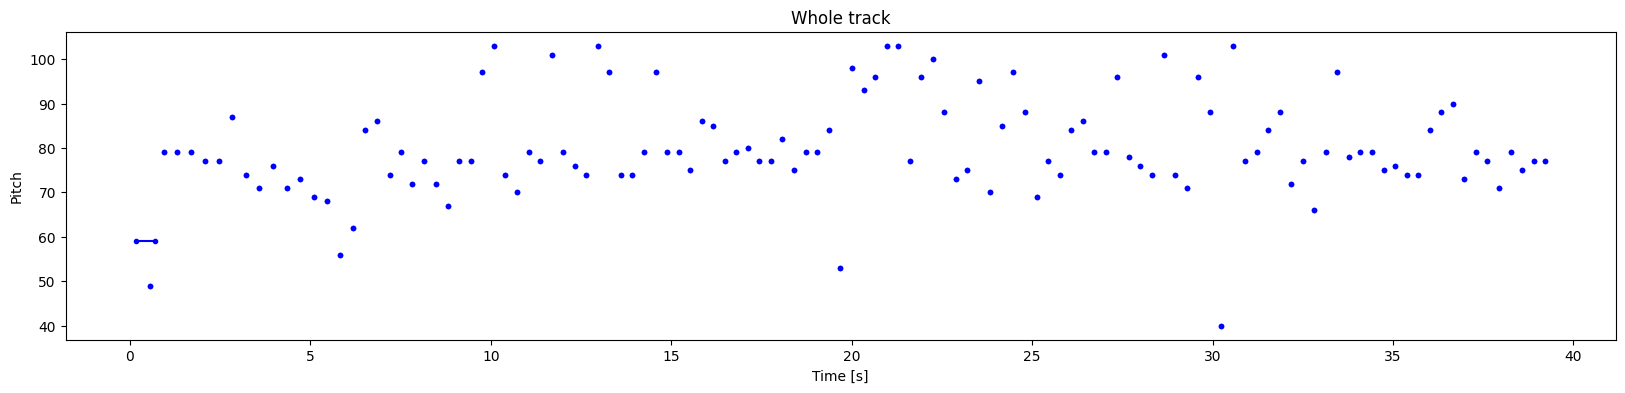

In [75]:
plot_piano_roll(generated_notes)